In [31]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

from __future__ import print_function
import sympy as sym
x, y = sym.symbols('x[0], x[1]')
ue = sym.sin(sym.pi*x)*sym.cos(sym.pi*y)

# Exact Solution
ue = sym.simplify(ue)
u_code = sym.printing.ccode(ue)
u_code = u_code.replace('M_PI','DOLFIN_PI')
print('u_exact = ' + u_code)

# du/dt - mu*Laplace(u) + div(bu) + sigma*u = f
fe = ue - (sym.diff(sym.diff(ue,x),x) + sym.diff(sym.diff(ue,y),y))

f_code = sym.printing.ccode(fe)
f_code = f_code.replace('M_PI','DOLFIN_PI')

print('u_ = '+ f_code)


u_exact = sin(DOLFIN_PI*x[0])*cos(DOLFIN_PI*x[1])
u_ = sin(DOLFIN_PI*x[0])*cos(DOLFIN_PI*x[1]) + 2*pow(DOLFIN_PI, 2)*sin(DOLFIN_PI*x[0])*cos(DOLFIN_PI*x[1])


In [32]:
from dolfin import *
import math as m
import numpy as np
import csv

u_code
u_exact = Expression(u_code, degree = 1)
u_ = Expression(f_code, degree = 1)

In [33]:
def compute_errors(u_e, u):
    """Compute various measures of the error u - u_e, where
    u is a finite element Function and u_e is an Expression."""

    # L2 norm
    E5 = errornorm(u_e, u, norm_type='L2', degree_rise=3)

    # H1 seminorm
    E6 = errornorm(u_e, u, norm_type='H10', degree_rise=3)

    # Collect error measures in a dictionary with self-explanatory keys
    errors = {'L2 norm': E5,
              'H10 seminorm': E6}

    return errors


myfile = 'error_filter.csv'


In [34]:
def testfilter(nx, u_exact, u_):
    S = 1.0 #scale such that delta = S*h
    P = 1    # polynomial degree of FE
    R = P

    mesh = UnitSquareMesh(nx,nx)
    h = CellDiameter(mesh)
    Q = FunctionSpace(mesh, "CG", P)
    
    # Set up boundary condition
    def boundary(x, on_boundary):
        return on_boundary
    u_D = Expression(u_exact.cppcode, degree = R)
    bc = DirichletBC(Q, u_D, boundary)

    # Test and trial functions
    u, v = TrialFunction(Q), TestFunction(Q)
    u_ = Function(Q)

    #delta = S*1.0/nx
    delta = 1.0
    
    u_tilde0 = Function(Q)

    # Define variational problem for step 2a (apply Helmholz filter)
    # Note: only RHS changes, so we can keep the same a2 throughout

    a2 = v*u*dx + delta*delta*dot(grad(v), grad(u))*dx #lhs(F_Hfilter)
    A2 = assemble(a2)

    def L2(u_): # input is intermediate velocity OR previous u_tilde solution
        L2 = v*u_*dx
        return L2

    # Step 2a Solve Helmholtz filter
    # N=0
    
    b2_0 = assemble(L2(u_))
    bc_0 = DirichletBC(Q, u_D, boundary)
    bc_0.apply(b2_0)
    bc_0.apply(A2)
    solve(A2, u_tilde0.vector(), b2_0)

    L2 = errornorm(u_exact, u_tilde0, norm_type='L2', degree_rise=3)

    # H1 seminorm
    H1_0 = errornorm(u_exact, u_tilde0, norm_type='H10', degree_rise=3)
    H1 = np.sqrt(L2**2 + H1_0**2) 
    print('nx =',nx,', L2norm = ', L2, ', H1norm = ', H1)


In [35]:
for nx in [25,50,100,200]:#400,800]:
    testfilter(nx, u_exact, u_)
    np.array

nx = 25 , L2norm =  0.176022189228 , H1norm =  1.27935939844
nx = 50 , L2norm =  0.176154300281 , H1norm =  1.27871424243
nx = 100 , L2norm =  0.176187803659 , H1norm =  1.27855498637
nx = 200 , L2norm =  0.1761962092 , H1norm =  1.27851529993


In [30]:
testfilter(40,u_exact,u_)

nx = 40 , L2norm =  0.176129297521 , H1norm =  1.27883421946


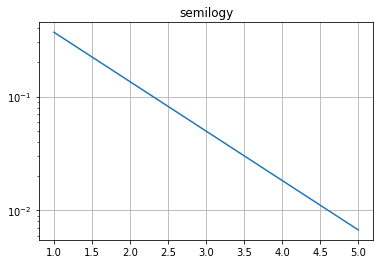

In [41]:
# log y axis
t = np.array([1, 2, 3, 4, 5])
plt.semilogy(t, np.exp(-t))
plt.title('semilogy')
plt.grid(True)

In [ ]:
    
    # Define indicator function to evaluate current time step
    def a(u_tilde, u_, t):
        indicator = Expression('sqrt((a-b)*(a-b))', degree = 2, a = u_, b = u_tilde)
        indicator = interpolate(indicator, Q)
        max_ind = np.amax(indicator.vector().get_local())#.vector().array())

        # Normalize indicator such that it's between [0,1].
        if max_ind < 1:
           max_ind = 1.0

        indicator = Expression('a/b', degree = 2, a = indicator, b = max_ind)
        indicator = interpolate(indicator, Q) 
        indicator.rename('a','a')
        #out_file_ind << (indicator, float(t))
        return indicator
    
    # Define variational problem for step 2b (evaluate indicator and find filtered solution)
    def a3(ind):
        a3 = v*u*dx + delta*delta*dot(grad(v), ind*grad(u))*dx
        return a3
    L3 = v*u_*dx

    
            DF = Expression('a', degree = R, a=u_tilde0)

        # Step 2b Calculate Indicator and solve Ind Problem
        ind = a(DF, u_, float(t))

        A3 = assemble(a3(ind))
        bc.apply(A3)

        b3 = assemble(L3)
        bc.apply(b3)

        solve(A3, u_bar.vector(), b3, "gmres")

In [ ]:

    ffile = open(myfile,"a+")
    if near(lvl, 1):
        outputf1 = methodname+' N = '+str(N)+', t = '+str(t)+"\n"
        ffile.write(outputf1)

    outputf = '\nLevel '+str(lvl)+', nx = '+str(nx)+'\n'
    ffile.write(outputf)

    w = csv.writer(open(myfile, "a+"))
    for key, val in errors.items():
        w.writerow([key, val])

    lvl += 1